# Evaluate Trained Cardinal Wind Agents

In [97]:
from systems.long_multirotor_sliding_error import LongTrajEnv

from typing import Union, Iterable, List
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm, trange
import optuna

from rl import learn_rl, transform_rl_policy, evaluate_rl, PPO, load_agent
from multirotor.simulation import Multirotor
from multirotor.helpers import DataLog
from multirotor.visualize import plot_datalog
from multirotor.controller import Controller
from multirotor.trajectories import Trajectory, GuidedTrajectory
from multirotor.controller.scurves import SCurveController
from systems.multirotor_sliding_error import MultirotorTrajEnv, VP
from multirotor.controller import (
    AltController, AltRateController,
    PosController, AttController,
    VelController, RateController,
    Controller
)
from scripts.opt_multirotorenv import get_established_controller
from utilities import get_agent
import pickle

In [98]:
study, best_agent, best_params = get_agent('highwind')

[I 2023-09-13 11:47:06,287] Using an existing study with name 'highwind' instead of creating a new one.


In [99]:
best_params['bounding_rect_length']=200
best_params['steps_u']=50
best_params['scaling_factor'] = 5

In [100]:
best_params

{'scaling_factor': 5,
 'window_distance': 10,
 'policy_layers': 3,
 'policy_size': 128,
 'learning_rate': 0.0005557590377310718,
 'n_epochs': 4,
 'n_steps': 10400,
 'batch_size': 64,
 'training_interactions': 200000,
 'bounding_rect_length': 200,
 'steps_u': 50}

In [101]:
def get_env(wind_ranges, scurve=False, **kwargs):  
    kw = dict(
        safety_radius=kwargs['safety_radius'],
        vp=VP,get_controller_fn=lambda m: get_established_controller(m),
        steps_u=kwargs['steps_u'],
        scaling_factor=kwargs['scaling_factor'],
        wind_ranges=wind_ranges,
        proximity=5, # have to get within 5m of waypoint
        seed=kwargs['seed'])
    return MultirotorTrajEnv(**kw)

In [102]:
def get_long_env(best_params, wind_range):
    env_kwargs = dict(
        safety_radius=5, # safety radius of 5m
        seed=0,
        get_controller_fn=lambda m: get_established_controller(m),
        vp = VP,
    )

    env_kwargs['steps_u'] = best_params['steps_u']
    env_kwargs['scaling_factor'] = best_params['scaling_factor']

    square_np = np.array([[100,0,0], [100,100,0], [0,100,0], [0,0,0]])
    square_traj = Trajectory(None, points=square_np, resolution=best_params['bounding_rect_length']) 
    square_wpts = square_traj.generate_trajectory(curr_pos=np.array([0,0,0]))

    env = LongTrajEnv(
        waypoints = square_wpts,
        base_env = get_env(wind_ranges = wind_range , **env_kwargs),
        initial_waypoints = square_np,
        randomize_direction=False,
        # window_distance=best_params['window_distance']
    )

    return env

In [103]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / np.linalg.norm(v1)
            ttes.append(tte)
                
        return np.array(ttes)

In [104]:
# what ranges of wind to evaluate the agent for
all_wind_ranges = [[(0,0), (0,0), (0,0)],
                               [(0,0), (5,5), (0,0)],
                               [(0,0), (7,7), (0,0)],
                               [(0,0), (10,10), (0,0)],
                               [(0,0), (-5,-5), (0,0)],
                               [(0,0), (-7,-7), (0,0)],
                               [(0,0), (-10,-10), (0,0)],
                               [(5,5), (0,0), (0,0)],
                               [(7,7), (0,0), (0,0)],
                               [(10,10), (0,0), (0,0)],
                               [(-5,-5), (0,0), (0,0)],
                               [(-7,-7), (0,0), (0,0)],
                               [(-10,-10), (0,0), (0,0)]]

### 0 m/s wind

In [105]:
wind_range = all_wind_ranges[0]
env = get_long_env(best_params, wind_range)

In [106]:
best_params

{'scaling_factor': 5,
 'window_distance': 10,
 'policy_layers': 3,
 'policy_size': 128,
 'learning_rate': 0.0005557590377310718,
 'n_epochs': 4,
 'n_steps': 10400,
 'batch_size': 64,
 'training_interactions': 200000,
 'bounding_rect_length': 200,
 'steps_u': 50}

In [107]:
done = False
state = env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))
vels = []
while not done:
    action = best_agent.predict(state, deterministic=True)[0]
    # action[1] = action[1] - 1
    vels.append(action)
    state, reward, done, info = env.step(action)
    log.log(reward=reward)

vels = np.array(vels) * best_params['scaling_factor']/2
log.done_logging()

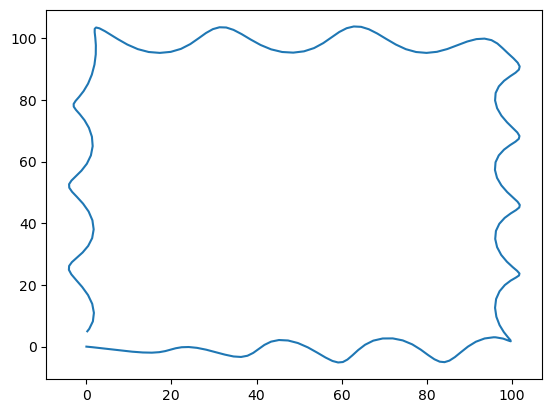

In [108]:
plt.plot(log.x, log.y)

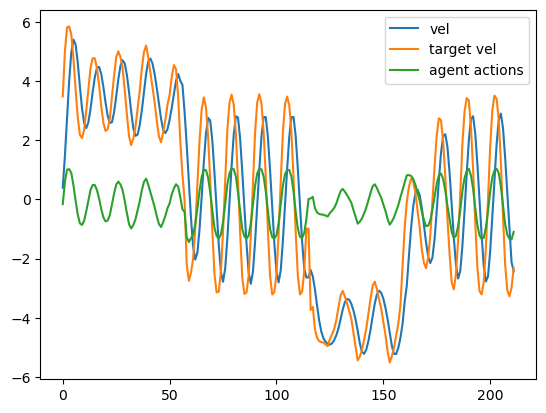

In [109]:
plt.plot(log.velocity[:,0], label='vel')
plt.plot(log.target.velocity[:,0], label='target vel')
plt.plot(vels[:,0], label='agent actions')
# plt.plot(log.target.position[:,0]) add in the change in waypoint
plt.legend()

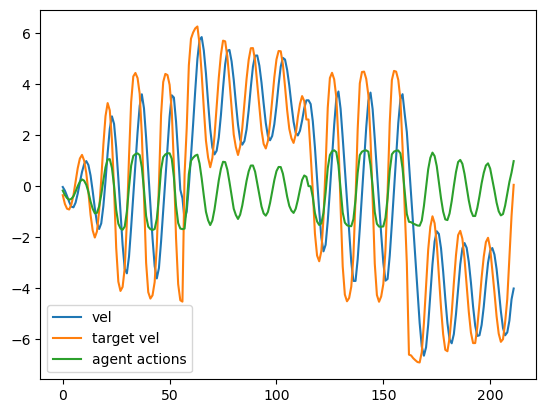

In [110]:
plt.plot(log.velocity[:,1], label='vel')
plt.plot(log.target.velocity[:,1], label='target vel')
plt.plot(vels[:,1], label='agent actions')
plt.legend()

In [111]:
np.sum(log.reward)

5168.077

## North

### 5 m/s wind

In [112]:
wind_range = all_wind_ranges[1]
env = get_long_env(best_params, wind_range)

In [113]:
done = False
state = env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))
while not done:
    action = best_agent.predict(state, deterministic=True)[0]
    state, reward, done, info = env.step(action)
    log.log(reward=reward)

log.done_logging()

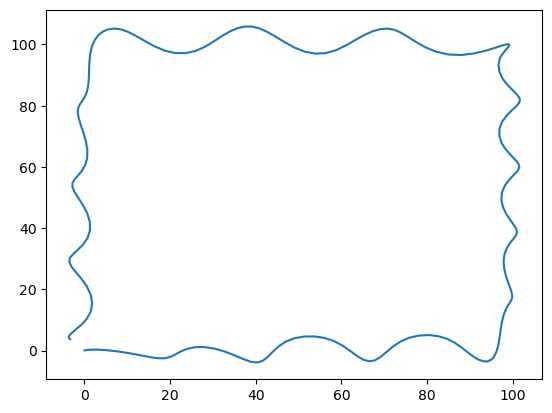

In [114]:
plt.plot(log.x, log.y)

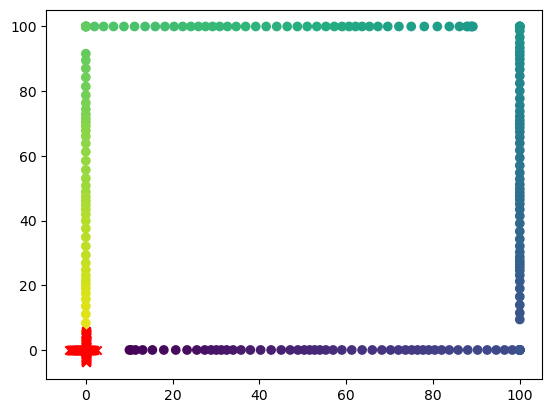

In [115]:
plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
plt.scatter(log.states[:,12], log.states[:,13], marker='x', color='red')

In [116]:
np.sum(log.reward)

5013.1074

### 7 m/s wind

In [117]:
wind_range = all_wind_ranges[2]
env = get_long_env(best_params, wind_range)

In [118]:
done = False
state = env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))

total_reward = 0
while not done:
    action = best_agent.predict(state, deterministic=True)[0]
    state, reward, done, info = env.step(action)
    log.log(reward=reward)

log.done_logging()

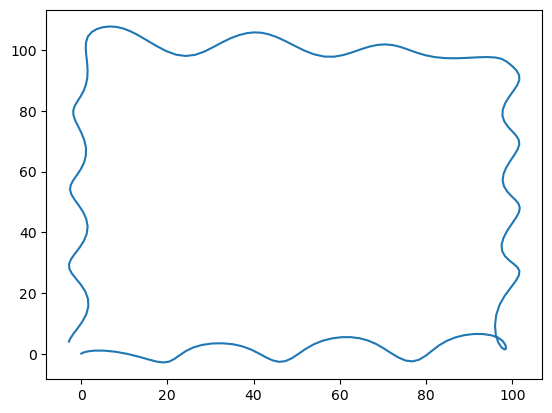

In [119]:
plt.plot(log.x, log.y)

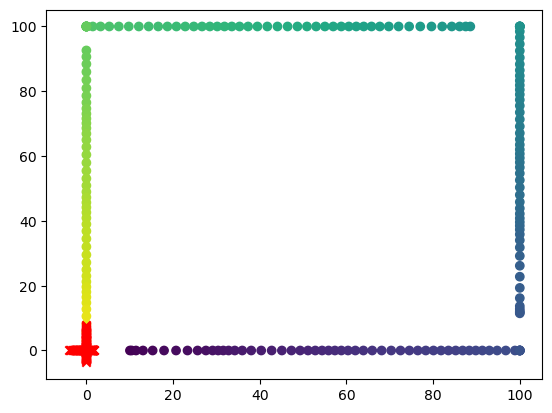

In [120]:
plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
plt.scatter(log.states[:,12], log.states[:,13], marker='x', color='red')

In [121]:
np.sum(log.reward)

4553.8174

### 10 m/s wind

In [122]:
wind_range = all_wind_ranges[3]
env = get_long_env(best_params, wind_range)

In [123]:
done = False
state = env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))

total_reward = 0
while not done:
    action = best_agent.predict(state, deterministic=True)[0]
    state, reward, done, info = env.step(action)
    log.log(reward=reward)

log.done_logging()

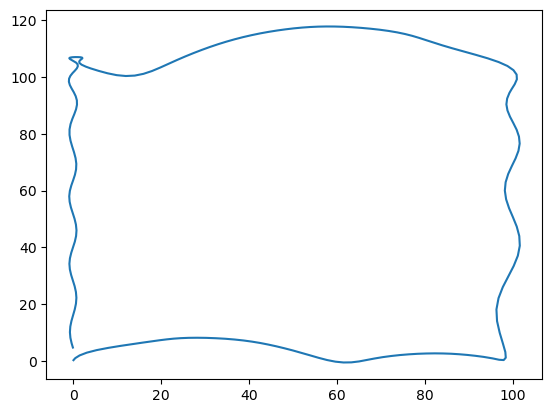

In [124]:
plt.plot(log.x, log.y)

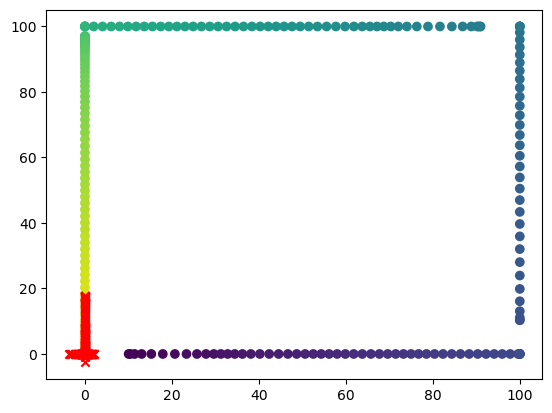

In [125]:
plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
plt.scatter(log.states[:,12], log.states[:,13], marker='x', color='red')

In [126]:
np.sum(log.reward)

-173.25244

## South

### 5 m/s wind

In [127]:
wind_range = all_wind_ranges[4]
env = get_long_env(best_params, wind_range)

In [128]:
done = False
state = env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))
while not done:
    action = best_agent.predict(state, deterministic=True)[0]
    state, reward, done, info = env.step(action)
    log.log(reward=reward)

log.done_logging()

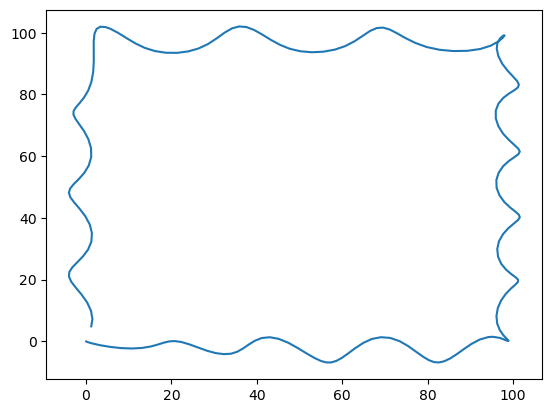

In [129]:
plt.plot(log.x, log.y)

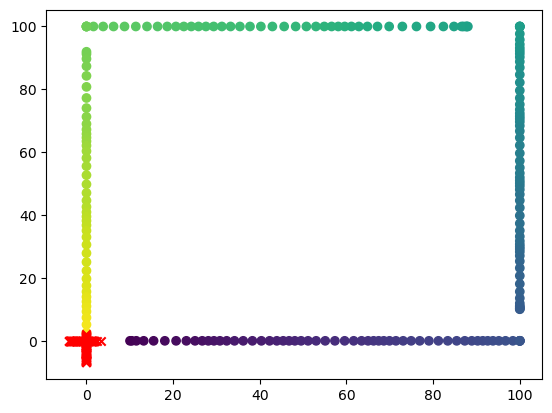

In [130]:
plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
plt.scatter(log.states[:,12], log.states[:,13], marker='x', color='red')

In [131]:
np.sum(log.reward)

4673.1562

### 7 m/s wind

In [132]:
wind_range = all_wind_ranges[5]
env = get_long_env(best_params, wind_range)

In [133]:
done = False
state = env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))

vels = []
total_reward = 0
while not done:
    action = best_agent.predict(state, deterministic=True)[0]
    vels.append(action)
    state, reward, done, info = env.step(action)
    log.log(reward=reward)

vels = np.array(vels)
log.done_logging()

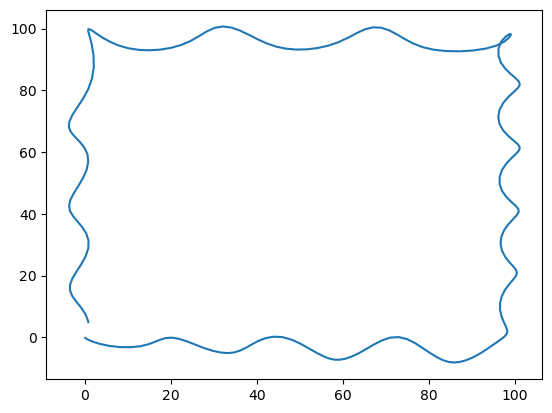

In [134]:
plt.plot(log.x, log.y)

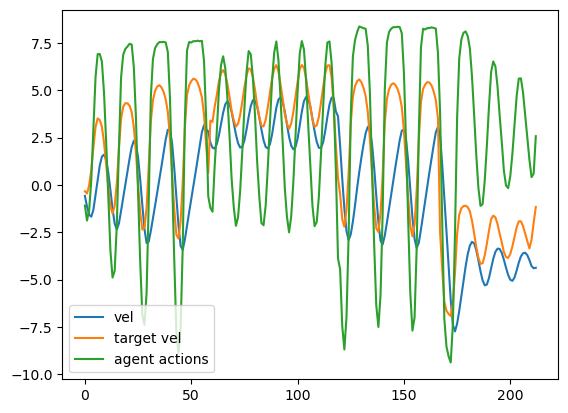

In [135]:
plt.plot(log.velocity[:,1], label='vel')
plt.plot(log.target.velocity[:,1], label='target vel')
plt.plot(vels[:,1]*15, label='agent actions')
plt.legend()

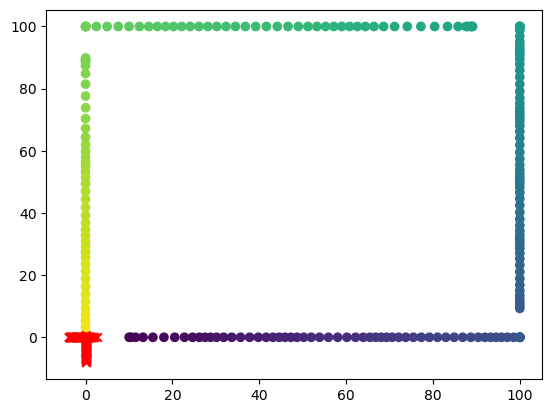

In [136]:
plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
plt.scatter(log.states[:,12], log.states[:,13], marker='x', color='red')

In [137]:
np.sum(log.reward)

4029.7231

### 10 m/s wind

In [138]:
wind_range = all_wind_ranges[6]
env = get_long_env(best_params, wind_range)

In [139]:
done = False
state = env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))

total_reward = 0
vels = []
while not done:
    action = best_agent.predict(state, deterministic=True)[0]
    vels.append(action)
    state, reward, done, info = env.step(action)
    log.log(reward=reward)

log.done_logging()

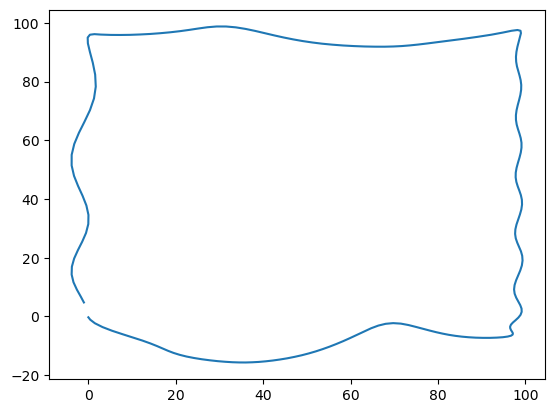

In [140]:
plt.plot(log.x, log.y)

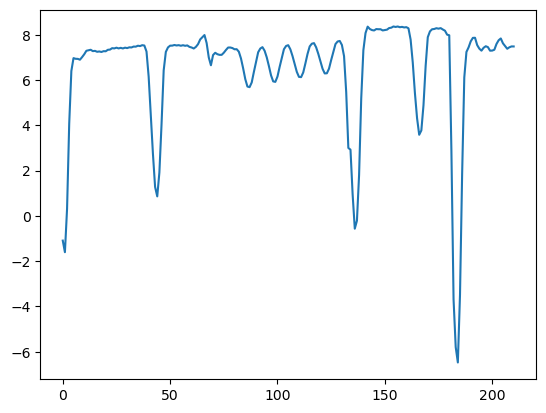

In [141]:
plt.plot(np.array(vels)[:,1]*15)

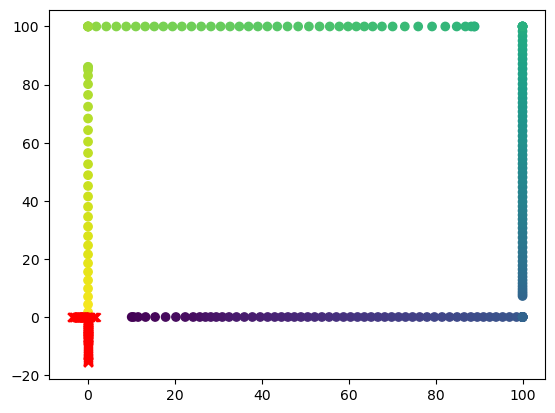

In [142]:
plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
plt.scatter(log.states[:,12], log.states[:,13], marker='x', color='red')

In [143]:
np.sum(log.reward)

236.96167

## East

### 5 m/s wind

In [144]:
wind_range = all_wind_ranges[7]
env = get_long_env(best_params, wind_range)

In [145]:
done = False
state = env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))
while not done:
    action = best_agent.predict(state, deterministic=True)[0]
    state, reward, done, info = env.step(action)
    log.log(reward=reward)

log.done_logging()

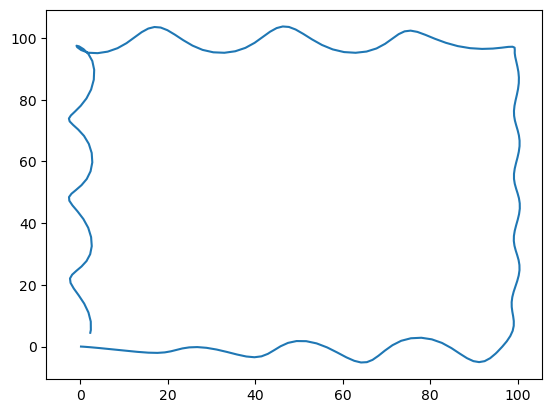

In [146]:
plt.plot(log.x, log.y)

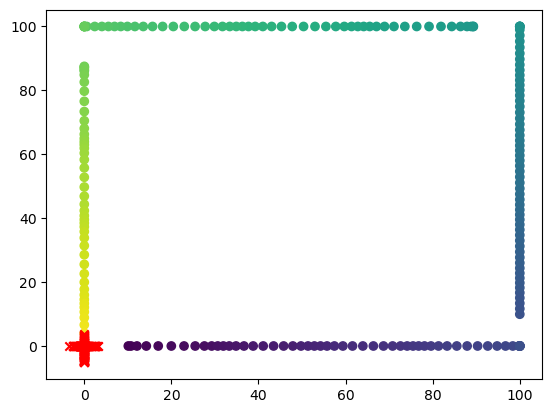

In [147]:
plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
plt.scatter(log.states[:,12], log.states[:,13], marker='x', color='red')

In [148]:
np.sum(log.reward)

5873.444

### 7 m/s wind

In [149]:
wind_range = all_wind_ranges[8]
env = get_long_env(best_params, wind_range)

In [150]:
done = False
state = env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))

total_reward = 0
while not done:
    action = best_agent.predict(state, deterministic=True)[0]
    state, reward, done, info = env.step(action)
    log.log(reward=reward)

log.done_logging()

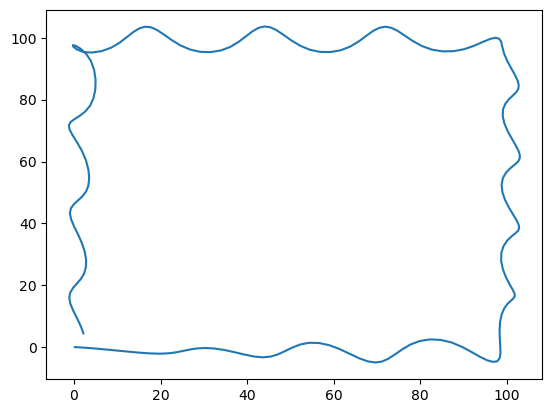

In [151]:
plt.plot(log.x, log.y)

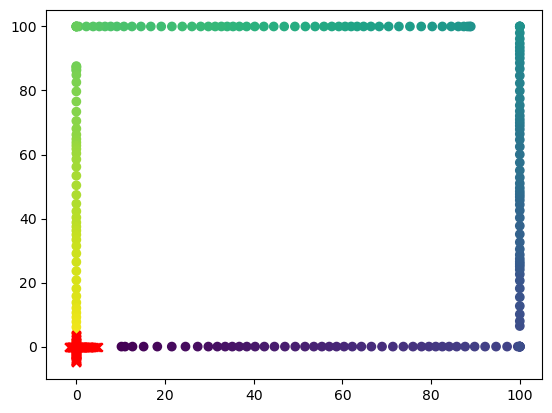

In [152]:
plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
plt.scatter(log.states[:,12], log.states[:,13], marker='x', color='red')

In [153]:
np.sum(log.reward)

5644.8613

### 10 m/s wind

In [154]:
wind_range = all_wind_ranges[9]
env = get_long_env(best_params, wind_range)

In [155]:
done = False
state = env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))

total_reward = 0
while not done:
    action = best_agent.predict(state, deterministic=True)[0]
    state, reward, done, info = env.step(action)
    log.log(reward=reward)

log.done_logging()

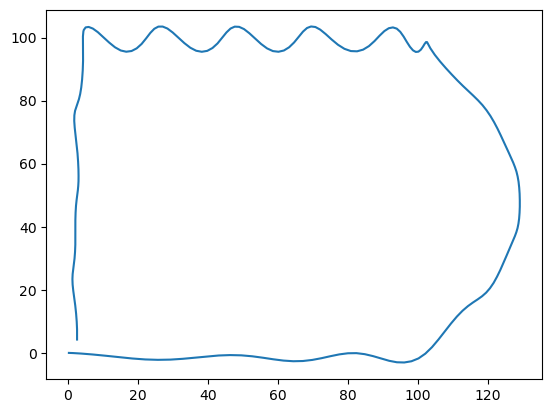

In [156]:
plt.plot(log.x, log.y)

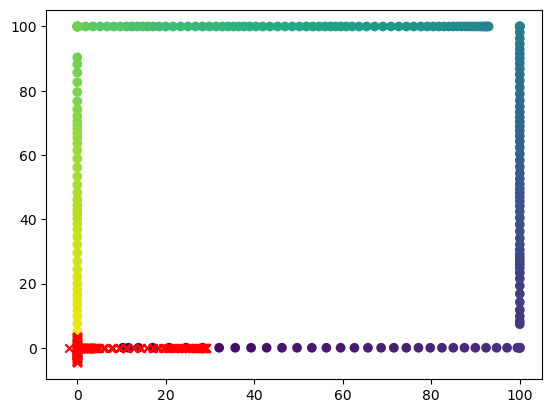

In [157]:
plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
plt.scatter(log.states[:,12], log.states[:,13], marker='x', color='red')

In [158]:
np.sum(log.reward)

-5012.5186

## West

### 5 m/s wind

In [159]:
wind_range = all_wind_ranges[10]
env = get_long_env(best_params, wind_range)

In [160]:
done = False
state = env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))
while not done:
    action = best_agent.predict(state, deterministic=True)[0]
    state, reward, done, info = env.step(action)
    log.log(reward=reward)

log.done_logging()

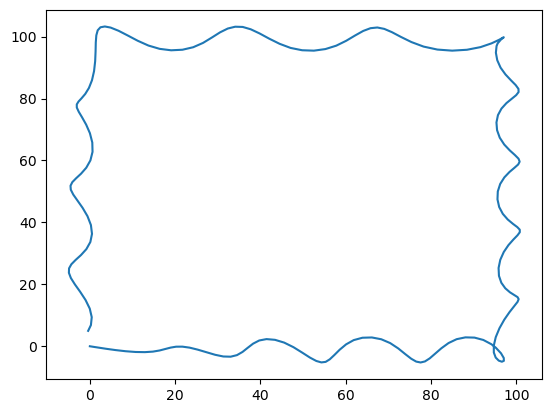

In [161]:
plt.plot(log.x, log.y)

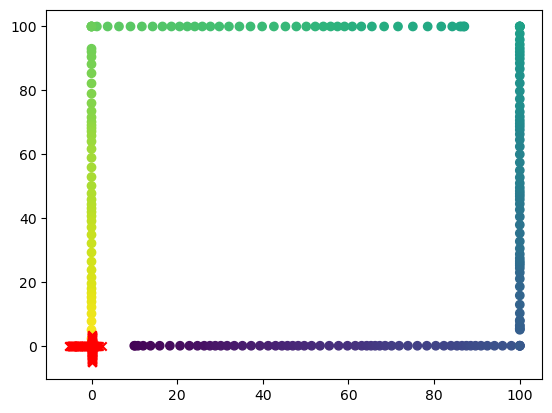

In [162]:
plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
plt.scatter(log.states[:,12], log.states[:,13], marker='x', color='red')

In [163]:
np.sum(log.reward)

4643.468

### 7 m/s wind

In [164]:
wind_range = all_wind_ranges[11]
env = get_long_env(best_params, wind_range)

In [165]:
done = False
state = env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))
vels = []

total_reward = 0
while not done:
    action = best_agent.predict(state, deterministic=True)[0]
    vels.append(action)
    state, reward, done, info = env.step(action)
    log.log(reward=reward)

log.done_logging()
vels = np.array(vels)

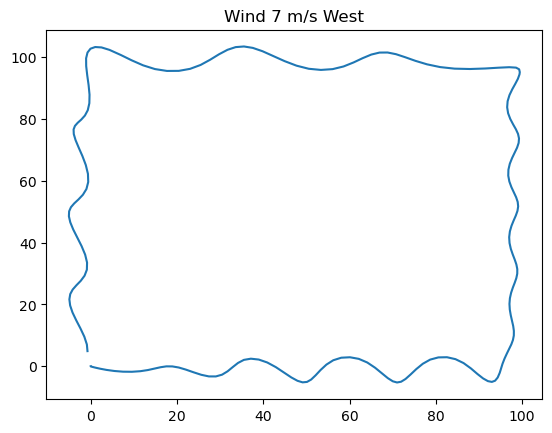

In [166]:
plt.title("Wind 7 m/s West")
plt.plot(log.x, log.y)

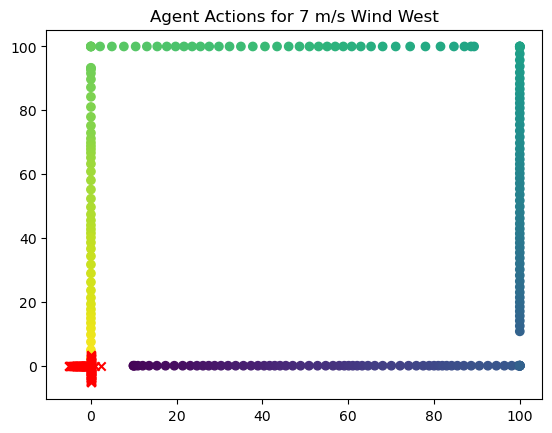

In [167]:
plt.title("Agent Actions for 7 m/s Wind West")
plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
plt.scatter(log.states[:,12], log.states[:,13], marker='x', color='red')
# plt.xlim(30, 37)

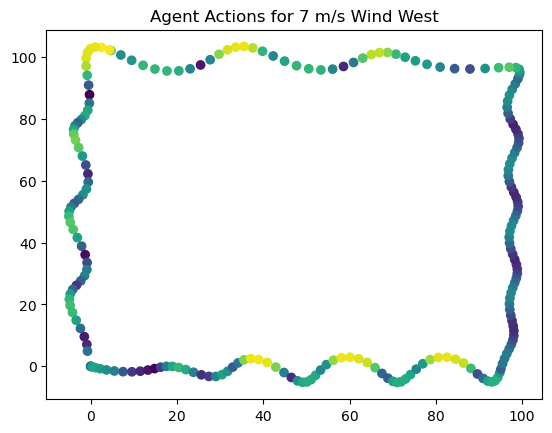

In [168]:
plt.title("Agent Actions for 7 m/s Wind West")
# plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
plt.scatter(log.x, log.y, c=np.linalg.norm(vels, axis=1), label='Speed')

Text(0.5, 0, 'Timesteps')

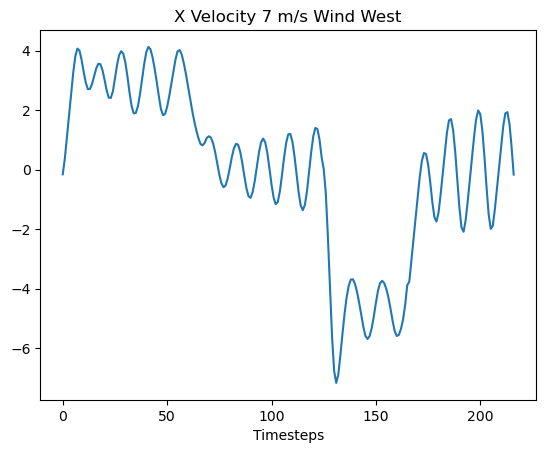

In [169]:
plt.title("X Velocity 7 m/s Wind West")
plt.plot(log.velocity[:,0])
plt.xlabel("Timesteps")

In [170]:
np.sum(log.reward)

4481.5312

### 10 m/s wind

In [171]:
wind_range = all_wind_ranges[12]
env = get_long_env(best_params, wind_range)

In [172]:
done = False
state = env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))
vels = []

total_reward = 0
while not done:
    action = best_agent.predict(state, deterministic=True)[0]
    vels.append(action)
    state, reward, done, info = env.step(action)
    log.log(reward=reward)

vels = np.array(vels)
log.done_logging()

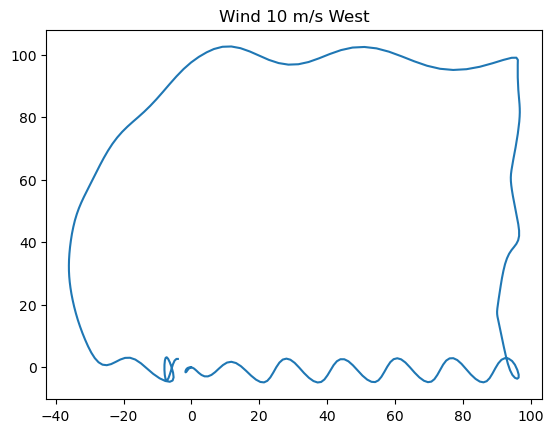

In [173]:
plt.title("Wind 10 m/s West")
plt.plot(log.x, log.y)

(30.0, 37.0)

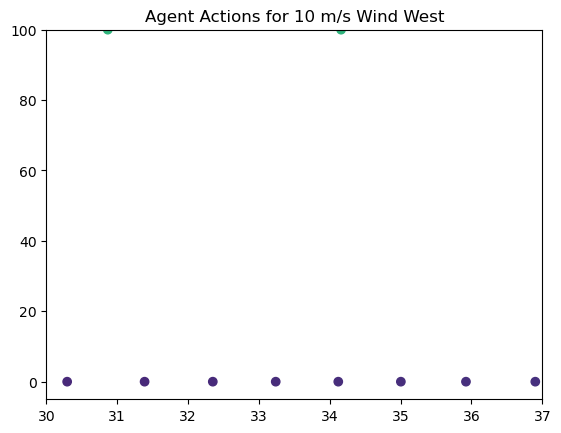

In [174]:
plt.title("Agent Actions for 10 m/s Wind West")
plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
plt.scatter(log.states[:,12], log.states[:,13], marker='x', color='red')
plt.ylim(-5,100)
plt.xlim(30, 37)

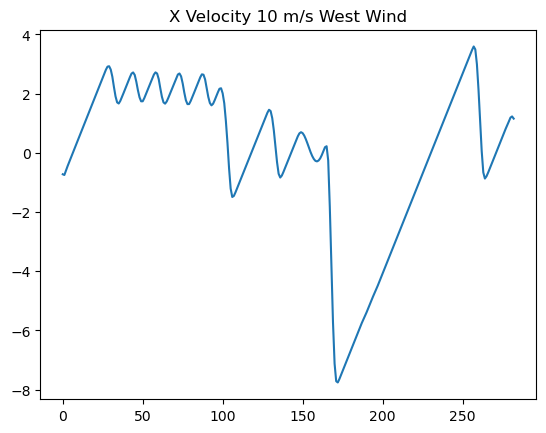

In [175]:
plt.title("X Velocity 10 m/s West Wind")
plt.plot(log.velocity[:,0])

In [176]:
np.sum(log.reward)

-13964.08

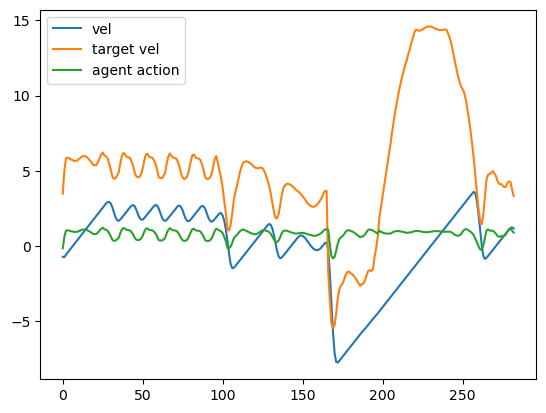

In [177]:
plt.plot(log.velocity[:,0], label='vel')
plt.plot(log.target.velocity[:,0], label='target vel')
plt.plot(vels[:,0]*(best_params['scaling_factor']/2), label='agent action')
plt.legend()

In [178]:
def calculate_safe_sliding_bound(reference_point, intersection_point, distance=5):
        reference_point = np.array(reference_point)
        intersection_point = np.array(intersection_point)
        
        # Calculate the vector from the point to the reference point
        vector_to_reference = reference_point - intersection_point
        
        # Calculate the distance between the point and the reference point
        distance_to_reference = np.linalg.norm(vector_to_reference)
        
        if distance_to_reference <= distance:
            # If the distance is within the specified range, return the reference point
            return reference_point
        else:
            # Calculate the intermediate point that is 'distance' units along the vector_to_reference
            intermediate_point = intersection_point + (distance / distance_to_reference) * vector_to_reference
            return intermediate_point

In [179]:
calculate_safe_sliding_bound([100,0,0], [10,0,0])

array([15.,  0.,  0.])

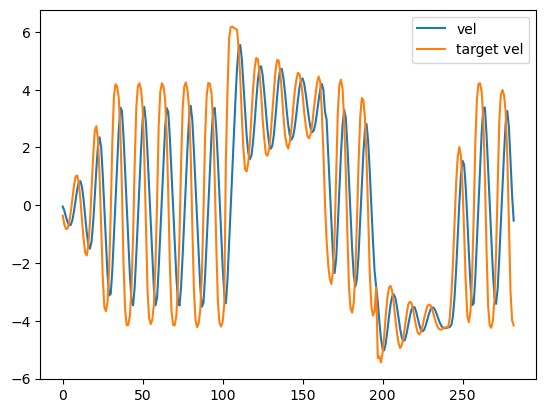

In [180]:
plt.plot(log.velocity[:,1], label='vel')
plt.plot(log.target.velocity[:,1], label='target vel')
plt.legend()

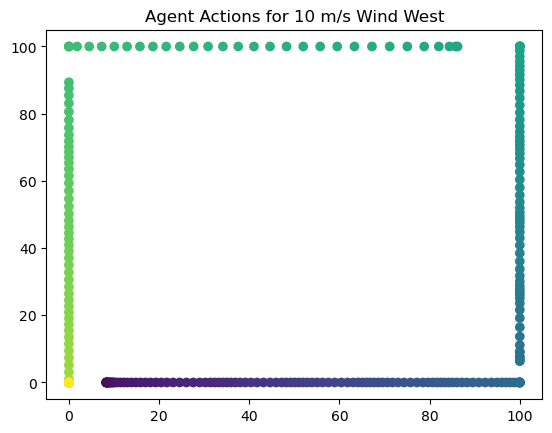

In [181]:
plt.title("Agent Actions for 10 m/s Wind West")
plt.scatter(log.target.position[:,0], log.target.position[:,1], c=range(len(log.target.position)))
# plt.scatter(log.x, log.y, c=log.target.velocity[:,0])
# plt.xlim(30, 37)

In [182]:
plt.scatter(log.states[:,18], log.states[:,19])

IndexError: index 18 is out of bounds for axis 1 with size 15